# Linear Regression using XGBoost

- `Pandas`, `Scikit-learn` for cleaning data
- `Matplotlib`, `Seaborn` for some basic visualizations
- `Scikit-learn` for scaling
- `XGBoost` for predictions

### 1. Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import category_encoders as ce

import xgboost as xgb

### 2. Loading the `train` dataset
Before starting on any task, it is useful to get more familiar with your dataset.

In [2]:
df_train = pd.read_csv('train.csv').set_index('Id')
print ('The shape of df_train is: ', df_train.shape)
df_train.head(2)

The shape of df_train is:  (1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


- Target values are stored in a Numpy scalar `y_train`

In [3]:
y_train_raw = np.array(df_train['SalePrice'])
# print y_train_raw
print(f"y_train_raw Shape: {y_train_raw.shape}, y_train_raw Type: {type(y_train_raw)})")
print("First element of y_train_raw are:\n", y_train_raw[:])
print("Dimension of y_train_raw:", y_train_raw.ndim)

y_train_raw Shape: (1460,), y_train_raw Type: <class 'numpy.ndarray'>)
First element of y_train_raw are:
 [208500 181500 223500 ... 266500 142125 147500]
Dimension of y_train_raw: 1


### 3. Visualize your data
* Correlated columns with `SalePrice`

In [4]:
corr = df_train.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr.SalePrice.head(7)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64

- It is often useful to understand the data by visualizing it.

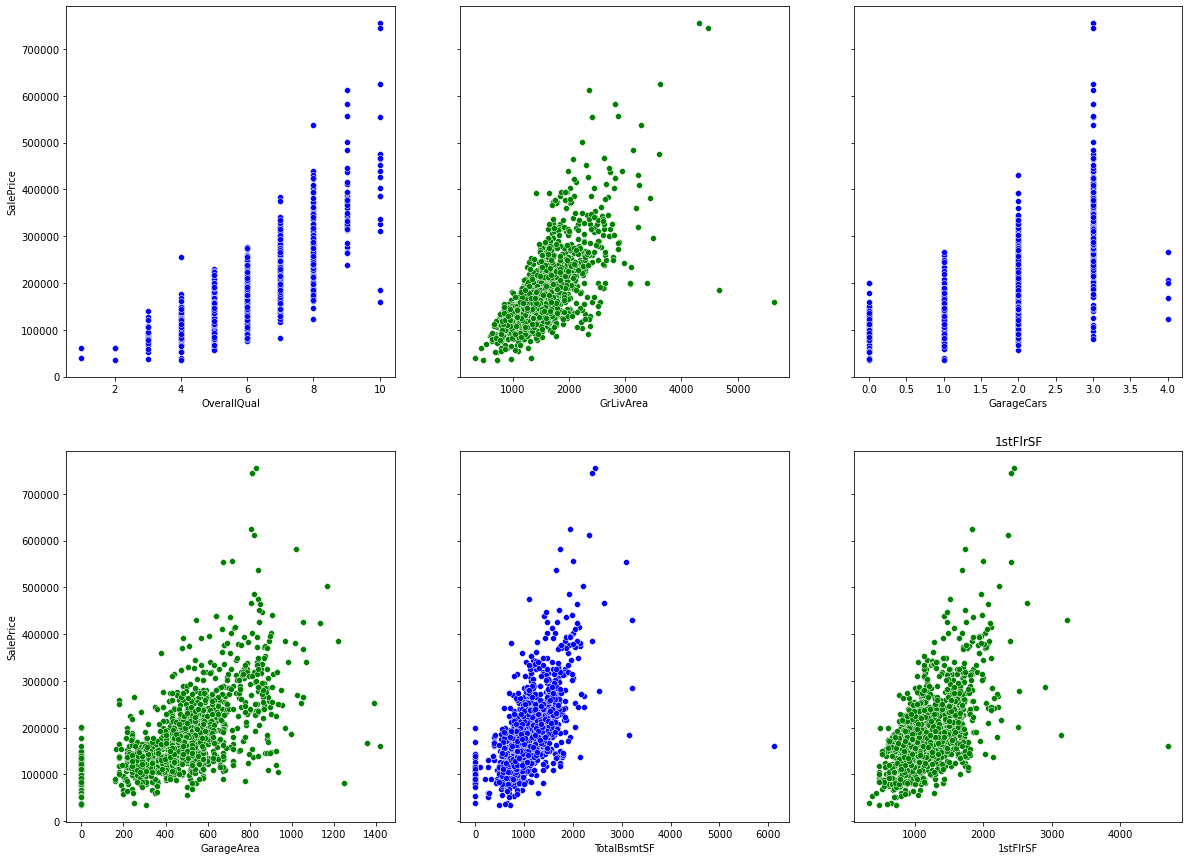

In [5]:
fig, axes = plt.subplots(2,3, figsize=(20,15), sharey=True)

plt.title('OverallQual')
sns.scatterplot(ax=axes[0,0], data=df_train, x='OverallQual', y='SalePrice', color='b')
plt.title('GrLivArea')
sns.scatterplot(ax=axes[0,1], data=df_train, x='GrLivArea', y='SalePrice', color='g')
plt.title('GarageCars')
sns.scatterplot(ax=axes[0,2], data=df_train, x='GarageCars', y='SalePrice', color='b')
plt.title('GarageArea')
sns.scatterplot(ax=axes[1,0], data=df_train, x='GarageArea', y='SalePrice', color='g')
plt.title('TotalBsmtSF')
sns.scatterplot(ax=axes[1,1], data=df_train, x='TotalBsmtSF', y='SalePrice', color='b')
plt.title('1stFlrSF')
sns.scatterplot(ax=axes[1,2], data=df_train, x='1stFlrSF', y='SalePrice', color='g')

plt.show()

* Histogram `['SalePrice']` on `train` set

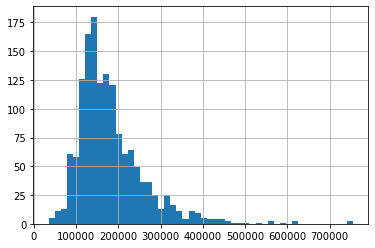

In [6]:
df_train['SalePrice'].hist(bins = 50);

### 4. Loading the `test` dataset

In [7]:
df_test = pd.read_csv('test.csv').set_index('Id')
print ('The shape of df_test is: ', df_test.shape)
df_test.head(2)

The shape of df_test is:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


### 5. Scaling and category encoder

- Choosing numeric features on `train` set and leaving out `SalePrice`

In [8]:
df_train.drop('SalePrice', axis=1, inplace=True)

In [9]:
select_numeric_features = make_column_selector(dtype_include=np.number)

In [10]:
numeric_features_train = select_numeric_features(df_train)

print(f'N numeric_features_train: {len(numeric_features_train)} \n')
print(', '.join(numeric_features_train))

N numeric_features_train: 36 

MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold


- Visualizing numeric features on `test` set

In [11]:
numeric_features_test = select_numeric_features(df_test)

print(f'N numeric_features_test: {len(numeric_features_test)} \n')
print(', '.join(numeric_features_test))

N numeric_features_test: 36 

MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold


#### Impute missing features values using a descriptive statistic `mean`, and normalize numeric features using `StandardScaler`

- `train` & `test` sets

In [12]:
df_train.fillna(np.nan, inplace=True)
df_test.fillna(np.nan, inplace=True)

numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

##### Cardinality categorical features

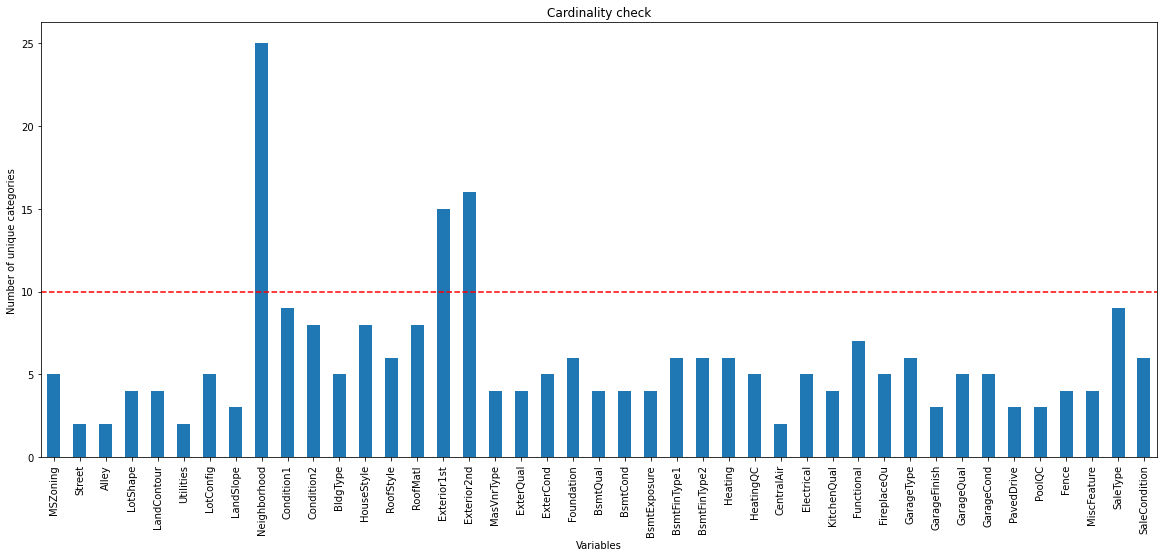

In [13]:
df_train_object = df_train.select_dtypes(include="object")
df_train_object.nunique().plot.bar(figsize=(20,8))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality check')
plt.axhline(y = 10, color= 'r', linestyle='--')
plt.show()

#### Categorical with moderate-to-low cardinality

In [14]:
MAX_OH_CARDINALITY = 10

def select_oh_features(df):
    
    hc_features =\
        df\
        .select_dtypes(['object', 'category'])\
        .apply(lambda col: col.nunique())\
        .loc[lambda x: x <= MAX_OH_CARDINALITY]\
        .index\
        .tolist()
        
    return hc_features

oh_features = select_oh_features(df_train)

print(f'N oh_features: {len(oh_features)} \n')
print(', '.join(oh_features))

N oh_features: 40 

MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition


In [15]:
oh_pipeline = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))

#### Categorical with high cardinality

In [16]:
def select_hc_features(df):
    
    hc_features =\
        df\
        .select_dtypes(['object', 'category'])\
        .apply(lambda col: col.nunique())\
        .loc[lambda x: x > MAX_OH_CARDINALITY]\
        .index\
        .tolist()
        
    return hc_features


hc_features = select_hc_features(df_train)

print(f'N hc_features: {len(hc_features)} \n')
print(', '.join(hc_features))

N hc_features: 3 

Neighborhood, Exterior1st, Exterior2nd


In [17]:
hc_pipeline = make_pipeline(ce.GLMMEncoder())

#### Putting it all together

In [18]:
column_transformer = ColumnTransformer(transformers = 
                                       [('numeric_pipeline', numeric_pipeline, select_numeric_features),
                                        ('oh_pipeline', oh_pipeline, select_oh_features),
                                        ('hc_pipeline', hc_pipeline, select_hc_features)],
                      remainder='drop')

In [19]:
X_train_trsf = column_transformer.fit_transform(df_train, y_train_raw)
X_test_trsf = column_transformer.transform(df_test)

print(X_train_trsf.shape)
print(X_test_trsf.shape)

(1460, 251)
(1459, 251)


- Checking `train` set transformed as `numpy.ndarray`

In [20]:
print(np.sum(np.isnan(X_train_trsf)))

0


In [21]:
print("X_train_trsf Type     :", type(X_train_trsf))
print(f"X_train_trsf Shape    : {X_train_trsf.shape}")
print("X_train_trsf Dimension:", X_train_trsf.ndim)

X_train_trsf Type     : <class 'numpy.ndarray'>
X_train_trsf Shape    : (1460, 251)
X_train_trsf Dimension: 2


Normalize and encoder `train` examples are stored in a Numpy matriz `X_train_trsf`.

In [22]:
#print("First element of X_train_trsf are:\n", X_train_trsf[:1])

- Checking `test` set transformed as `numpy.ndarray`

In [23]:
print(np.sum(np.isnan(X_test_trsf)))

0


In [24]:
print("X_test_trsf Type     :", type(X_test_trsf))
print(f"X_test_trsf Shape    : {X_test_trsf.shape}")
print("X_test_trsf Dimension:", X_test_trsf.ndim)

X_test_trsf Type     : <class 'numpy.ndarray'>
X_test_trsf Shape    : (1459, 251)
X_test_trsf Dimension: 2


Normalize and encoder `test` examples are stored in a Numpy matriz `X_test_trsf`.

In [25]:
#print("First element of X_test_trsf are:\n", X_test_trsf[:1])

### 6. Fit the model with `XGBoost`

- Separate data into *training* and *validation* sets

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_trsf, y_train_raw, test_size=0.3, random_state=0)

- Shape and Dimensions

In [27]:
print(f"X_train Shape    : {X_train.shape},| y_train Shape    : {y_train.shape}")
print("X_train Dimension:", X_train.ndim, "          | y_train Dimension:", y_train.ndim)
print(f"X_valid Shape    : {X_valid.shape}, | y_valid Shape    : {y_valid.shape}")
print("X_valid Dimension:", X_valid.ndim, "          | y_valid Dimension:", y_valid.ndim)

X_train Shape    : (1022, 251),| y_train Shape    : (1022,)
X_train Dimension: 2           | y_train Dimension: 1
X_valid Shape    : (438, 251), | y_valid Shape    : (438,)
X_valid Dimension: 2           | y_valid Dimension: 1


#### `XGBRegressor`

In [28]:
model_0 = xgb.XGBRegressor()
model_0.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
predictions_0 = model_0.predict(X_valid)

print("R2 Score                           : " + str(r2_score(y_valid, predictions_0)))
print("Mean Absolute Error                : " + str(mean_absolute_error(y_valid, predictions_0)))
print("Mean Square Error                  : " + str(mean_squared_error(y_valid, predictions_0)))
print("Mean Squared Logarithmic Error     : " + str(mean_squared_log_error(y_valid, predictions_0)))
print("Root Mean Square Error             : " + str(np.sqrt(mean_squared_error(y_valid, predictions_0))))
print("Root Mean Squared Logarithmic Error: " + str(np.sqrt(mean_squared_log_error(y_valid, predictions_0))))

# ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

R2 Score                           : 0.8504492661014049
Mean Absolute Error                : 17622.04422624144
Mean Square Error                  : 1015298652.4273086
Mean Squared Logarithmic Error     : 0.018041121697764163
Root Mean Square Error             : 31863.751386604003
Root Mean Squared Logarithmic Error: 0.1343172427418169


- Parameter Tuning 1

In [30]:
model_1 = xgb.XGBRegressor(n_estimators=500)
model_1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
predictions_1 = model_1.predict(X_valid)

print("R2 Score                           : " + str(r2_score(y_valid, predictions_1)))
print("Mean Absolute Error                : " + str(mean_absolute_error(y_valid, predictions_1)))
print("Mean Square Error                  : " + str(mean_squared_error(y_valid, predictions_1)))
print("Mean Squared Logarithmic Error     : " + str(mean_squared_log_error(y_valid, predictions_1)))
print("Root Mean Square Error             : " + str(np.sqrt(mean_squared_error(y_valid, predictions_1))))
print("Root Mean Squared Logarithmic Error: " + str(np.sqrt(mean_squared_log_error(y_valid, predictions_1))))

# ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

R2 Score                           : 0.8505283444050589
Mean Absolute Error                : 17637.974395333906
Mean Square Error                  : 1014761790.5006354
Mean Squared Logarithmic Error     : 0.018035117454934715
Root Mean Square Error             : 31855.325936185858
Root Mean Squared Logarithmic Error: 0.13429488990626082


- Parameter Tuning 2

In [32]:
model_2 = xgb.XGBRegressor(n_estimators=1000)
model_2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
predictions_2 = model_2.predict(X_valid)

print("R2 Score                           : " + str(r2_score(y_valid, predictions_2)))
print("Mean Absolute Error                : " + str(mean_absolute_error(y_valid, predictions_2)))
print("Mean Square Error                  : " + str(mean_squared_error(y_valid, predictions_2)))
print("Mean Squared Logarithmic Error     : " + str(mean_squared_log_error(y_valid, predictions_2)))
print("Root Mean Square Error             : " + str(np.sqrt(mean_squared_error(y_valid, predictions_2))))
print("Root Mean Squared Logarithmic Error: " + str(np.sqrt(mean_squared_log_error(y_valid, predictions_2))))

# ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

R2 Score                           : 0.8505292716784018
Mean Absolute Error                : 17637.91680936073
Mean Square Error                  : 1014755495.2498475
Mean Squared Logarithmic Error     : 0.018035021935490676
Root Mean Square Error             : 31855.227126012578
Root Mean Squared Logarithmic Error: 0.13429453427258564


- Parameter Tuning 3

>**GridSearchCV**: Best parameters: `(n_estimators=500, max_depth=5, colsample_bylevel=0.4, learning_rate=3.0e-2)`

In [34]:
model_3 = xgb.XGBRegressor(n_estimators=500, max_depth=5, colsample_bylevel=0.4, learning_rate=3.0e-2)
model_3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [35]:
predictions_3 = model_3.predict(X_valid)

print("R2 Score                           : " + str(r2_score(y_valid, predictions_3)))
print("Mean Absolute Error                : " + str(mean_absolute_error(y_valid, predictions_3)))
print("Mean Square Error                  : " + str(mean_squared_error(y_valid, predictions_3)))
print("Mean Squared Logarithmic Error     : " + str(mean_squared_log_error(y_valid, predictions_3)))
print("Root Mean Square Error             : " + str(np.sqrt(mean_squared_error(y_valid, predictions_3))))
print("Root Mean Squared Logarithmic Error: " + str(np.sqrt(mean_squared_log_error(y_valid, predictions_3))))

# ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

R2 Score                           : 0.8919786610323069
Mean Absolute Error                : 14985.002782534246
Mean Square Error                  : 733355945.6930393
Mean Squared Logarithmic Error     : 0.013918001025460012
Root Mean Square Error             : 27080.545520595395
Root Mean Squared Logarithmic Error: 0.11797457787786321


* Outlier

In [36]:
np.sum(predictions_3 < 0)

0

In [37]:
print("Shape of predictions_3:", predictions_3.shape)
print("Dimension of predictions_3:", predictions_3.ndim)

Shape of predictions_3: (438,)
Dimension of predictions_3: 1


### 12. Make predictions on `test` set
Make predictions using best model `model_3`

In [38]:
predictions_test = model_3.predict(X_test_trsf)

print("R2 Score                           : " + str(r2_score(y_train_raw[:1459,], predictions_test)))
print("Mean Absolute Error                : " + str(mean_absolute_error(y_train_raw[:1459,], predictions_test)))
print("Mean Square Error                  : " + str(mean_squared_error(y_train_raw[:1459,], predictions_test)))
print("Mean Squared Logarithmic Error     : " + str(mean_squared_log_error(y_train_raw[:1459,], predictions_test)))
print("Root Mean Square Error             : " + str(np.sqrt(mean_squared_error(y_train_raw[:1459,], predictions_test))))
print("Root Mean Squared Logarithmic Error: " + str(np.sqrt(mean_squared_log_error(y_train_raw[:1459,], predictions_test))))

# ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

R2 Score                           : -0.9171910436155453
Mean Absolute Error                : 80296.71729620031
Mean Square Error                  : 12098137228.470667
Mean Squared Logarithmic Error     : 0.30590365334170083
Root Mean Square Error             : 109991.5325307847
Root Mean Squared Logarithmic Error: 0.553085575062034


### Back to Pandas for submitting predictions

In [39]:
submission = pd.DataFrame(dict(Id=df_test.index, SalePrice=predictions_test))
submission.head

<bound method NDFrame.head of         Id      SalePrice
0     1461  124117.875000
1     1462  156254.296875
2     1463  188386.375000
3     1464  192688.640625
4     1465  196134.187500
...    ...            ...
1454  2915   81536.976562
1455  2916   77432.382812
1456  2917  165558.750000
1457  2918  110576.359375
1458  2919  217230.828125

[1459 rows x 2 columns]>

In [40]:
submission.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,178869.687500
std,421.321334,76605.937500
min,1461.000000,42858.933594
25%,1825.500000,128313.187500
50%,2190.000000,158141.593750
75%,2554.500000,210583.867188
max,2919.000000,542077.562500


In [41]:
submission = submission.astype(int)

In [ ]:
#submission.to_csv('submission.csv', index=False, header=True)

## Acknowledgments

- Machine Learning Specialization offered jointly by DeepLearning.AI and Stanford University on Coursera.
- The housing data was derived from **Kaggle** [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview).
- Category Encoder: Scikit-Learn ColumnTransformer approach from [Kyle Gilde](https://www.kaggle.com/code/kylegilde/building-columntransformers-dynamically) on **Kaggle**

>Let me know if you have any recommendations.  Thanks!